# Autoencoder for MIDI

run tensorboard with `tensorboard --logdir=runs`

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import pad, silu
from torch.utils.tensorboard.writer import SummaryWriter
from torch.utils.data import Dataset, DataLoader, random_split

from torchinfo import summary

import os
import random
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

from typing import List

## Notebook Setup

### Dark Mode

In [2]:
plt.style.use("dark_background")

In [3]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
.jp-OutputArea-output {
   background-color: transparent;
}  
</style>

### Constants / Parameters

In [4]:
# constants
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
BATCH_SIZE = 32
NOISE_FACTOR = 0.05
AUGMENTATION_FACTOR = 5
OVERFIT = False

Move to GPU if available

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## Utility Functions

In [6]:
def plot_images(images: List, titles: List[str], set_axis="off"):
    num_images = len(images)
    for num_plot in range(num_images):
        plt.subplot(num_images, 1, num_plot + 1)
        plt.imshow(
            np.squeeze(images[num_plot]),
            aspect="auto",
            origin="lower",
            cmap="magma",
            interpolation="nearest",
        )
        plt.title(titles[num_plot])
        plt.axis(set_axis)

    plt.show()

In [7]:
def format_image(image, remove_time=True):
    # remove time factor
    if remove_time:
        image = np.delete(image, 0, axis=1)
    # add 1 dimension & ensure correct data type
    image = torch.from_numpy(np.expand_dims(image, 0)).to(torch.float32)
    # normalize to [0, 1]
    if torch.any(image > 1.0):
        image = image / image.max()
    # zero-pad to (1, 60, 412)
    image = pad(input=image, pad=(0, 12, 1, 1), mode="constant", value=0.0)

    return image

## Load Data

### Custom Dataset

In [8]:
class MIDILoopDataset(Dataset):
    def __init__(
        self,
        data: List,
        multiplier=1,
        transforms=None,
    ):
        self.data = data * multiplier
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        name, image = self.data[idx]
        if self.transforms:
            image = self.transforms(image)
        return name, image

### Augmentation Functions

In [9]:
def vert_shift(array, name: str, num_iterations: int = 1):
    shifted_images = []

    def find_non_zero_bounds(arr):
        """Find the first and last row index with a non-zero element"""
        rows_with_non_zero = np.where(arr.any(axis=1))[0]
        return rows_with_non_zero[0], rows_with_non_zero[-1]

    def shift_array(arr, up=0, down=0):
        """Shift array vertically within bounds"""
        if up > 0:
            arr = np.roll(arr, -up, axis=0)
            arr[-up:] = 0
        elif down > 0:
            arr = np.roll(arr, down, axis=0)
            arr[:down] = 0
        return arr

    highest, lowest = find_non_zero_bounds(array)
    maximum_up = highest
    maximum_down = array.shape[0] - lowest - 1

    for _ in range(num_iterations):
        # Shift up and then down, decreasing the shift amount in each iteration
        for i in range(maximum_up, 0, -1):
            new_key = f"{Path(name).stem}_u{i:02d}"
            shifted_images.append((new_key, np.copy(shift_array(array, up=i))))
        for i in range(maximum_down, 0, -1):
            new_key = f"{Path(name).stem}_d{i:02d}"
            shifted_images.append((new_key, np.copy(shift_array(array, down=i))))

    random.shuffle(shifted_images)

    return shifted_images[:num_iterations]

In [10]:
def augment_data(
    clean_images: List, factor: int = 1, vshift: bool = True, outfile: str | None = None
):
    """Augments a set of passed-in images by a factor of 2*factor"""
    shifted_images = []
    noisy_images = []

    for name, image in tqdm(clean_images, unit="images"):
        time_factor = image[:, 0]  # save manually included time factor
        image = np.delete(image, 0, axis=1)  # remove it from the image though
        if vshift:
            # vertical shift images
            shifted_images.append(vert_shift(image, name, factor))
        else:
            # reformat clean image array
            shifted_images.append([(name, image)])

        # add noise to images
        for si in shifted_images[-1]:
            new_key, shifted_image = si
            for _ in range(factor):
                # normalize
                noisy_image = shifted_image / np.max(shifted_image)

                # corrupt
                noisy_image = torch.from_numpy(
                    noisy_image
                ) + NOISE_FACTOR * torch.randn(noisy_image.shape)

                # reformat
                noisy_image = format_image(noisy_image, remove_time=False)

                noisy_images.append((new_key, noisy_image))

    random.shuffle(noisy_images)

    if outfile:
        np.savez_compressed(
            os.path.join("data", outfile),
            **{name: arr for name, arr in noisy_images},
        )

        del shifted_images
        del noisy_images

        return [], []

    return shifted_images, noisy_images

### Build Datasets

In [11]:
clean_dataset = np.load("data/all_loops.npz")
shifted_data, augmented_dataset = augment_data(
    list(clean_dataset.items()), AUGMENTATION_FACTOR
)

print(
    f"used {len(list(clean_dataset.keys()))} clean images to generate {len(augmented_dataset)} noisy images of shape {augmented_dataset[0][1].size()}"
)

  0%|          | 0/1404 [00:00<?, ?images/s]

used 1404 clean images to generate 35100 noisy images of shape torch.Size([1, 60, 412])


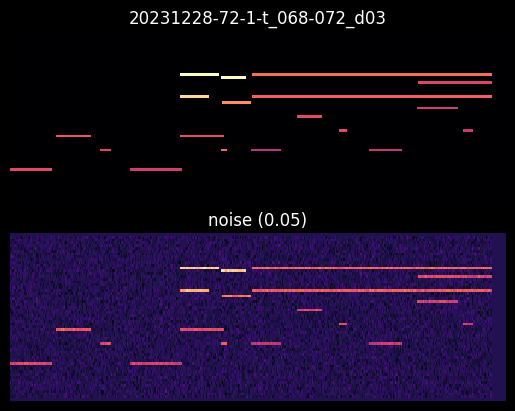

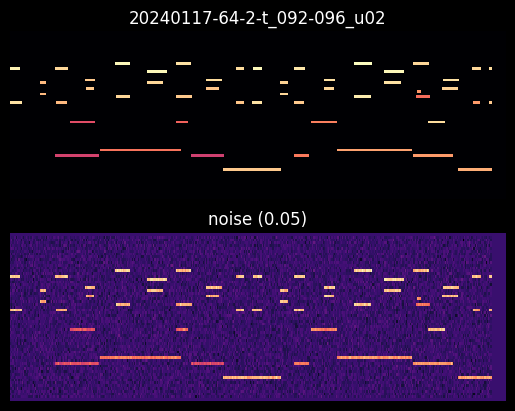

In [12]:
for k, v in augmented_dataset[:2]:
    clean_padded_image = format_image(clean_dataset[k[: k.rfind("_")] + ".mid"], True)
    plot_images([clean_padded_image, v], [k, f"modified ({NOISE_FACTOR}% noise)"])

In [13]:
input_set = MIDILoopDataset(augmented_dataset)
train_set, test_set = random_split(input_set, [0.8, 0.2])

trainLoader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
testLoader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

if OVERFIT:
    overfit_set = MIDILoopDataset([augmented_dataset[0]], multiplier=3200)
    trainLoader = DataLoader(
        overfit_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=4
    )

In [14]:
for batch in trainLoader:
    batch1 = batch
    break

print(batch1[1].shape)

torch.Size([32, 1, 60, 412])


## Autoencoder Setup

### Model

In [15]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder layers
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder layers
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.out = nn.Conv2d(64, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = self.pool(silu(self.enc1(x)))
        x = self.pool(silu(self.enc2(x)))
        x = self.pool(silu(self.enc3(x)))
        x = self.pool(silu(self.enc4(x)))

        # Decoder
        x = silu(self.dec1(x))
        x = silu(self.dec2(x))
        x = silu(self.dec3(x))
        x = silu(self.dec4(x))
        # x = torch.sigmoid(self.out(x))
        x = silu(self.out(x))

        return x


model = AutoEncoder().to(device)

In [16]:
print(model)

AutoEncoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [17]:
print(summary(model, (1, 58, 400)))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 60, 412]              --
├─Conv2d: 1-1                            [64, 58, 400]             640
├─MaxPool2d: 1-2                         [64, 29, 200]             --
├─Conv2d: 1-3                            [32, 29, 200]             18,464
├─MaxPool2d: 1-4                         [32, 14, 100]             --
├─Conv2d: 1-5                            [16, 14, 100]             4,624
├─MaxPool2d: 1-6                         [16, 7, 50]               --
├─Conv2d: 1-7                            [8, 7, 50]                1,160
├─MaxPool2d: 1-8                         [8, 3, 25]                --
├─ConvTranspose2d: 1-9                   [8, 7, 51]                584
├─ConvTranspose2d: 1-10                  [16, 15, 103]             1,168
├─ConvTranspose2d: 1-11                  [32, 30, 206]             2,080
├─ConvTranspose2d: 1-12                  [64, 60, 412]             

### Optimizer and Loss Functions

In [18]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Train and Test Functions

In [19]:
def train(net, trainLoader, num_epochs=NUM_EPOCHS, logging=True):
    train_loss = []
    if logging:
        writer = SummaryWriter(
            f"runs/{datetime.now().strftime('%y-%m-%d_%H%M%S')}_reset"
        )
    for epoch in trange(num_epochs, desc="Total"):
        running_loss = 0.0
        with tqdm(trainLoader, unit="batch") as tepoch:
            for i, (name, image) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch+1:02d}")
                # add noise to the image data
                img_noisy = image + NOISE_FACTOR * torch.randn(image.shape)
                # clip to make the values fall between 0 and 1
                img_noisy = np.clip(img_noisy, 0.0, 1.0)
                img_noisy = img_noisy.to(device)
                optimizer.zero_grad()
                outputs = net(img_noisy)

                loss = loss_fn(outputs, img_noisy)
                # backpropagation
                loss.backward()
                # update the parameters
                optimizer.step()
                running_loss += loss.item()
                tepoch.set_postfix(loss=f"{loss.item():03f}")

                if logging:
                    global_step = epoch * len(trainLoader) + i
                    writer.add_scalar("training/loss", loss.item(), global_step)
                    for p_name, param in model.named_parameters():
                        writer.add_histogram(
                            f"weights/{p_name}", param.data, global_step
                        )
                        if param.requires_grad:
                            writer.add_histogram(
                                f"gradients/{p_name}.grad", param.grad, global_step
                            )

            loss = running_loss / len(trainLoader)
            train_loss.append(loss)

    return train_loss

In [26]:
def test_image_reconstruction(net, loader, loss):
    for names, data in loader:
        img_noisy = data + NOISE_FACTOR * torch.randn(data.shape)
        # img_noisy = np.clip(img_noisy, 0.0, 1.0)
        img_noisy = img_noisy.to(device)

        outputs = net(img_noisy)
        og_filename = names[0][: names[0].rfind("_")] + ".mid"

        images = [
            format_image(clean_dataset[og_filename]),
            img_noisy[0].cpu().data,
            outputs[0].cpu().data,
        ]
        titles = [
            f"{names[0]} (epochs={NUM_EPOCHS})",
            f"noisy ({NOISE_FACTOR}% noise)",
            f"reconstructed (loss={loss:.03f})",
        ]

        plot_images(images, titles)
        break

## Train and Evaluation

### Train

In [ ]:
train_loss = train(model, trainLoader, NUM_EPOCHS)

### Eval

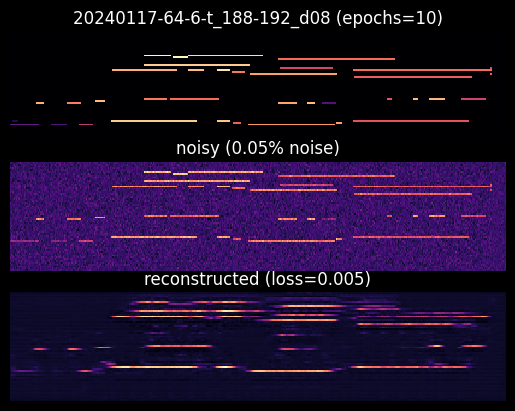

In [28]:
test_image_reconstruction(model, trainLoader, train_loss[-1])

###